In [3]:
import numpy as np
import seaborn as sb
import pandas as pd
from random import randint, choice
import torch
from importlib import reload

In [5]:
from gan.dataset import Dataset3D
ds = Dataset3D("TNG300-1", "MASS_1.00e+12_5.00e+12_MSUN", 256, "train", [])
dm = ds[0]["DM"]
gas = ds[0]["GAS"]

In [13]:
import visualization.slice_selection as ss

select_slice = ss.select_slice
sdm, sgas = select_slice(dm, gas, weight=0.4)

indexes = {16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104}
indexes = {64, 65, 66, 67, 68, 69, 70, 71, 72, 57, 58, 59, 60, 61, 62, 63}


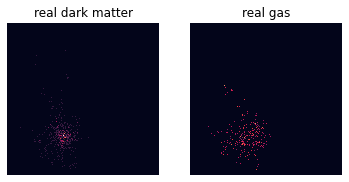

In [19]:
import visualization.heatmap as hm
reload(hm)

fig, ax = hm.heatmap_plot(sdm.squeeze(), sgas.squeeze(), title="Random title", subplot_titles=("real dark matter", "real gas"))